# Multimodal (Gaussian Mixture/Hidden Markov) Models for Motion-Sound Mapping — Quickstart guide

## Building and using the XMM Python library

See http://xmm.julesfrancoise.com

The python library reflects the sructure of the C++ library. The same classes and methods can be used on both implementations.
First, import the python library (needs to be within your Python search path

In [1]:
import xmm

## Using GMMs for classification

This example is inspired by the `test_gmm.y` file in the `python/examples`directory.

In this example, we illustrate the process of training and classification with Gaussian Mixture Models. We have 3 data files called "gmm_test_data1.txt", "gmm_test_data2.txt", "gmm_test_data3.txt". Each file contains a 2D array where each row is a data frame with 6 dimensions. The data was generated with the example patch from the Max/Mubu implementation (see http://julesfrancoise.com/mubu-probabilistic-models/)

### Building a training set

First, we need to record and annotate the training data. This is done using the `TrainingSet`class:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Create the training set
training_set = xmm.TrainingSet()
training_set.set_dimension(6) # dimension of data in this example
training_set.set_column_names(xmm.vectors(['a', 'b', 'c', 'd', 'e', 'f']))
# Record data phrases
for i in range(3):
    phrase = np.genfromtxt('data/gmm_test_data{}.txt'.format(i+1))
    for frame in phrase:
        # Append data frame to the phrase i
        training_set.recordPhrase(i, frame)
    # Set the label of the phrase of index i to i+1
    training_set.setPhraseLabel(i, xmm.Label(i+1))

For most objects of the library, calling the `print` function from python will print the JSON file description of the current object. In this case, we can have a look at the data contained in the training set:

In [ ]:
print training_set

The training Set has 3 classes with integer labels 1, 2 and 3.

### Training the models

We can now train a `GMMGroup` — i.e. a group of Gaussian Mixture Models with different class labels.
We start by creating an instance of the `GMMGroup`, that we construct with a pointer to the training set:

In [3]:
# Create a GMM Group (handles multiples labels for recognition)
gmm = xmm.GMMGroup()
# Set pointer to the training set
gmm.set_trainingSet(training_set)

We can now adjust the model parameters (number of Gaussians and regularization of the covariances) and train the models for all classes of the training set:

In [4]:
# Set parameters
gmm.set_nbMixtureComponents(10)
gmm.set_varianceOffset(1., 0.01)
# Train all models
gmm.train()
print "number of models: ", gmm.size()

number of models:  3


The models are now trained, and the group contains 3 classes. We can further inspect the results of the training, by iterating over the Labels within the model group:

In [5]:
for label in gmm.models.keys():
    print "model", label.getInt(), ": trained in ", gmm.models[label].trainingNbIterations, \
        "iterations, loglikelihood = ", gmm.models[label].trainingLogLikelihood

model 1 : trained in  19.0 iterations, loglikelihood =  1258.45452033
model 2 : trained in  31.0 iterations, loglikelihood =  1233.48572931
model 3 : trained in  25.0 iterations, loglikelihood =  1293.50319224


### Performing Recognition

The trained ModelGroup can be used directly to perform continuous recognition or classification with class-conditional GMMs.

We start by loading test data originatin from the same 3 distributions used for training:

In [6]:
# read test data (concatenation of 3 test examples labeled 1, 2, 3)
test_data = np.genfromtxt('data/gmm_test_data1.txt')
test_data = np.vstack((test_data, np.genfromtxt('data/gmm_test_data2.txt')))
test_data = np.vstack((test_data, np.genfromtxt('data/gmm_test_data3.txt')))

Then, we can set additional attributes of the models, such as the size of the window used to smooth the likelihoods, and initialize the "performance mode".
We create several arrays that will store the normalized likelihoods and log-likelihoods during continuous recognition, and we can then perform the recognition continuously and causally by updating the recognition with each new frame of the test examples:

In [7]:
# Set Size of the likelihood Window (samples)
gmm.set_likelihoodwindow(40)
# Initialize performance phase
gmm.performance_init()
# Create likelihood arrays for recognition
instantaneous_likelihoods = np.zeros((test_data.shape[0], gmm.size()))
normalized_likelihoods = np.zeros((test_data.shape[0], gmm.size()))
log_likelihoods = np.zeros((test_data.shape[0], gmm.size()))
# Performance: Play test data and record the likelihoods of the modes
for i in range(test_data.shape[0]):
    gmm.performance_update(xmm.vectorf(test_data[i, :]))
    instantaneous_likelihoods[i, :] = np.array(gmm.results_instant_likelihoods)
    normalized_likelihoods[i, :] = np.array(gmm.results_normalized_likelihoods)
    log_likelihoods[i, :] = np.array(gmm.results_log_likelihoods)

We can finally plotthe normalized and log-likelihoods over time:

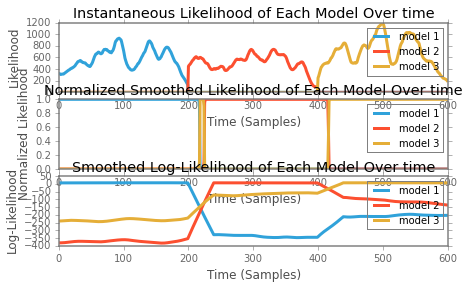

In [8]:
# Plot the likelihoods over time for the test phase
plt.figure()
plt.subplot(311)
plt.plot(instantaneous_likelihoods)
plt.title("Instantaneous Likelihood of Each Model Over time")
plt.xlabel("Time (Samples)")
plt.ylabel("Likelihood")
plt.legend(("model 1", "model 2", "model 3"))
plt.subplot(312)
plt.plot(normalized_likelihoods)
plt.title("Normalized Smoothed Likelihood of Each Model Over time")
plt.xlabel("Time (Samples)")
plt.ylabel("Normalized Likelihood")
plt.legend(("model 1", "model 2", "model 3"))
plt.subplot(313)
plt.plot(log_likelihoods)
plt.title("Smoothed Log-Likelihood of Each Model Over time")
plt.xlabel("Time (Samples)")
plt.ylabel("Log-Likelihood")
plt.legend(("model 1", "model 2", "model 3"))

Note that the trained model can be saved to a JSON file:

In [10]:
gmm.writeFile("test_gmm.json")

## Continuous Gesture Recognition and Following with the Hierarchical HMM

This example is inspired by the `test_hierarchicalhmm.y` file in the `python/examples`directory.

The data originates from the example patch: "hhmm_leapmotion_recognition.maxpat" of the Max implementation (see http://julesfrancoise.com/mubu-probabilistic-models/).
The data represents the XYZ Speed of the hand extracted from the leapmotion, rescaled (divided by 1000) and smoothed (moving average filter).

For this example, we assume a trained model(trained using the Max/MSP example patch). We just need to instanciate a `HierarchicalHMM` (which inherits from the ModelGroup class we evoked for GMMGroups):

In [10]:
# Create a single HMM (group of GMMs running in parallel for recognition)
hhmm = xmm.HierarchicalHMM()
# Read trained model from Json file
hhmm.readFile('data/hhmm_model.json')
print "number of models", hhmm.size()
print "labels:", [lab.getInt() for lab in hhmm.models.keys()]

number of models 3
labels: [1, 2, 3]


We consider a simple example of continuous recognition and folllowing with data originating from the concatenation of 3 recording, one from each class of gestures:

In [11]:
# read test data (concatenation of 1 example of each of the 3 classes)
test_data = np.genfromtxt('data/hhmm_test_data1.txt')
test_data = np.vstack((test_data, np.genfromtxt('data/hhmm_test_data2.txt')))
test_data = np.vstack((test_data, np.genfromtxt('data/hhmm_test_data3.txt')))

As before, we initialize the performance mode with the `performance_init` function and we can then proceed to continuous recognition where we update at each time step the model with the incoming data frame.
In this example, we store the instantaneous likelihood as well as its normalized version and the log-likelihood.
We also keep track of the "progress" within the model, which gives an estimate of the temporal progression of the current gesture.

In [12]:
# Initialize performance phase
hhmm.performance_init()
# Create arrays for likelihoods
instantaneous_likelihoods = np.zeros((test_data.shape[0], hhmm.size()))
normalized_likelihoods = np.zeros((test_data.shape[0], hhmm.size()))
log_likelihoods = np.zeros((test_data.shape[0], hhmm.size()))
progress = np.zeros((test_data.shape[0]))
# Performance: Play test data and record the likelihoods of the modes
for i in range(test_data.shape[0]):
    hhmm.performance_update(xmm.vectorf(test_data[i, :]))
    log_likelihoods[i, :] = np.array(hhmm.results_log_likelihoods)
    instantaneous_likelihoods[i, :] = np.array(hhmm.results_instant_likelihoods)
    normalized_likelihoods[i, :] = np.array(hhmm.results_normalized_likelihoods)
    progress[i] = hhmm.models[hhmm.results_likeliest].results_progress
    # Note: you could extract alphas and time progression as for HMM, for each model. E.g. : 
    # print np.array(hhmm.models[hhmm.results_likeliest].alpha)

We can Finally plot the likelihood of each model over time, which is estimated causally with a forward algorithm (therefore allowing a use in real-time).
The last plot depicts the temporal progression within the likeliest model, which gives an idea of how the new performance of the gesture is followed in time.

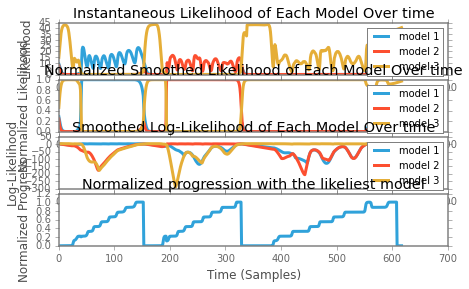

In [13]:
# Plot the likelihoods over time for the test phase
plt.figure()
plt.subplot(411)
plt.plot(instantaneous_likelihoods)
plt.title("Instantaneous Likelihood of Each Model Over time")
plt.xlabel("Time (Samples)")
plt.ylabel("Likelihood")
plt.legend(("model 1", "model 2", "model 3"))
plt.subplot(412)
plt.plot(normalized_likelihoods)
plt.title("Normalized Smoothed Likelihood of Each Model Over time")
plt.xlabel("Time (Samples)")
plt.ylabel("Normalized Likelihood")
plt.legend(("model 1", "model 2", "model 3"))
plt.subplot(413)
plt.plot(log_likelihoods)
plt.title("Smoothed Log-Likelihood of Each Model Over time")
plt.xlabel("Time (Samples)")
plt.ylabel("Log-Likelihood")
plt.legend(("model 1", "model 2", "model 3"))
plt.subplot(414)
plt.plot(progress)
plt.title("Normalized progression with the likeliest model")
plt.xlabel("Time (Samples)")
plt.ylabel("Normalized Progress")
plt.show()

## Motion-Sound Mapping with Hidden Markov Regression

TODO! Need to find some training data somewhere, maybe the shape stuff...